In [1]:
# Source: https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/grad_cam.py

import os
import json
import cv2
import numpy as np
import torch
from torch.nn import functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# --- setting ---
image_file = "./images/football.jpg"
labels_file = './labels.json'

# load model
# net = models.resnet18(weights='DEFAULT')
# target_layer = net.layer4
net = models.vgg16(weights='DEFAULT')
for module in net.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False
target_layer = net.features[28]

net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [3]:
# --- Grad-CAM Core Logic: Hook Configuration ---
values = {'activations': None, 'gradients': None}

def hook_forward(module, input, output):
    values['activations'] = output.detach()

def hook_backward(module, grad_input, grad_output):
    values['gradients'] = grad_output[0].detach()

# Register a 'forward_hook' on a specific layer
target_layer.register_forward_hook(hook_forward)
# Register a 'backward_hook' on a specific layer
target_layer.register_full_backward_hook(hook_backward)

# Preprocessing Settings
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Image load
img_pil = Image.open(image_file)
img_tensor = preprocess(img_pil)
img_input = img_tensor.unsqueeze(0)

In [4]:
# --- Grad-CAM Process ---
# Forward Pass
net.zero_grad()
logit = net(img_input)

# Select target class
h_x = F.softmax(logit, dim=1).squeeze()
probs, idx = h_x.sort(0, True)
target_idx = idx[0]  # top-1 predicted class

print(f"Prediction: {target_idx.item()} ({probs[0]:.3f})")

# Backward Pass
score = logit[0, target_idx]
score.backward()  # # Compute partial derivatives (dy^c / dA^k)

# Global Average Pooling on Gradients
gradients = values['gradients']  # [1, 512, 7, 7]
activations = values['activations']  # [1, 512, 7, 7]

# Channel-wise gradient average
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [1, 512, 1, 1]

# Linear combination of weights and feature maps
grad_cam = torch.sum(weights*activations, dim=1).squeeze()  # [7, 7]
grad_cam = F.relu(grad_cam)

# Normalization
grad_cam = grad_cam.cpu().numpy()
grad_cam -= np.min(grad_cam)
if np.max(grad_cam) != 0:
    grad_cam /= np.max(grad_cam)

Prediction: 805 (0.894)


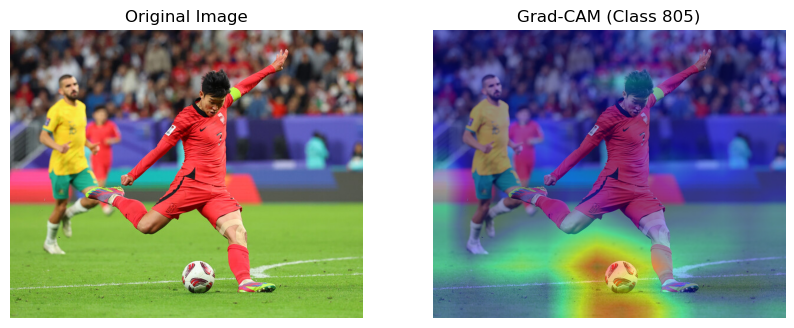

In [5]:
# --- Visualization ---
# Upsampling to match the original image size
size_upsample = (img_pil.size[0], img_pil.size[1])
grad_cam_rescaled = cv2.resize(grad_cam, size_upsample)

# Heatmap generation
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_rescaled), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Original image composition
img_np = np.array(img_pil)
result = (heatmap * 0.4 + img_np * 0.6).astype(np.uint8)

# Output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title(f"Grad-CAM (Class {target_idx.item()})")
plt.axis('off')

plt.show()